In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import setuptools.dist
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
# Load dataset from UCI repository
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(dataset_url, delimiter=';')

# Display basic dataset info
display(df.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [12]:
# Data preprocessing (Assuming target variable is 'quality')
X = df.drop(columns=['quality'])
y = df['quality']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Train an XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Train a simple neural network
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output layer
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test_scaled, y_test))

Epoch 1/50


c:\Users\shaak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 25.3878 - val_loss: 3.2319
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8379 - val_loss: 1.9903
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8150 - val_loss: 1.5964
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4932 - val_loss: 1.3210
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2506 - val_loss: 1.0875
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1355 - val_loss: 0.9235
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9716 - val_loss: 0.7965
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8229 - val_loss: 0.6976
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7150 - val_loss: 0.6317
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6248 - val_loss: 0.5897
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5633 - val_loss: 0.5210
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4850 - val_loss: 0.4907

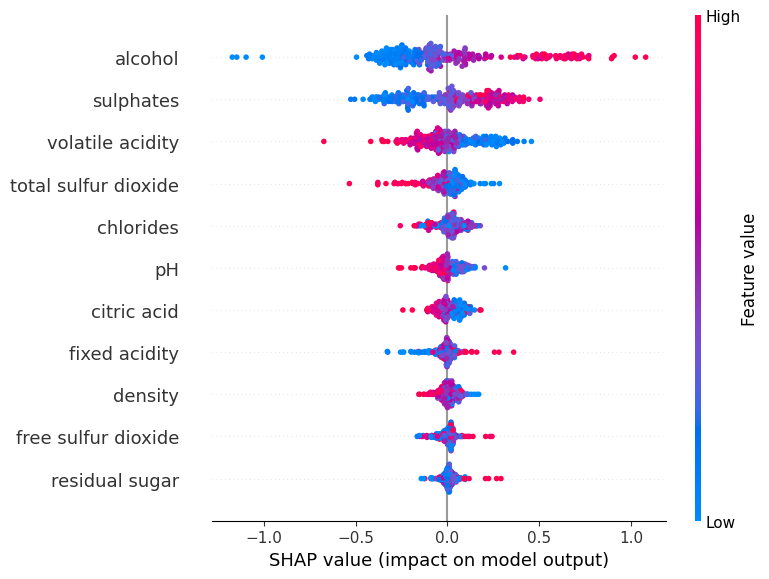

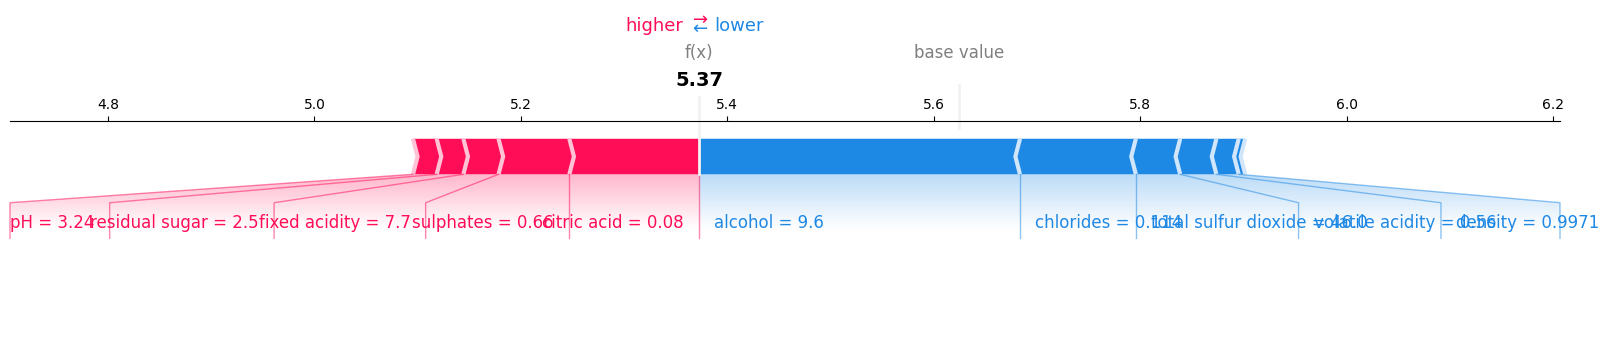

In [14]:
# SHAP explanation for XGBoost
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

# SHAP summary plot (Global explanation)
shap.summary_plot(shap_values_xgb, X_test)

# SHAP force plot for local explanation (first instance)
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0].values, X_test.iloc[0,:], matplotlib=True)


PermutationExplainer explainer: 321it [00:20,  9.59it/s]                         


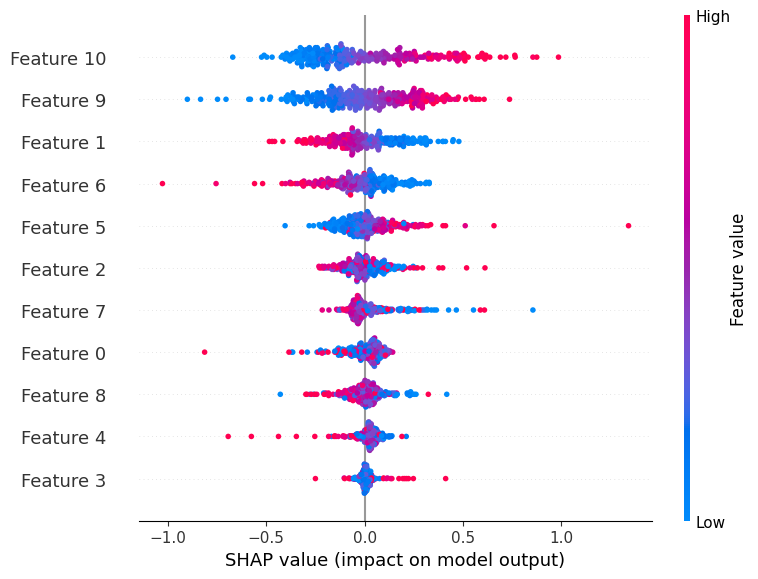

AttributeError: 'PermutationExplainer' object has no attribute 'expected_value'

In [15]:
# SHAP explanation for Neural Network
explainer_nn = shap.Explainer(model, X_train_scaled)
shap_values_nn = explainer_nn(X_test_scaled)

# SHAP summary plot for Neural Network
shap.summary_plot(shap_values_nn, X_test_scaled)

# SHAP force plot for first instance (Neural Network)
shap.force_plot(explainer_nn.expected_value, shap_values_nn[0].values, X_test_scaled[0], matplotlib=True)